## 1. Importação do Dataset e analise rapida

Dataset escolhido: Bitcoin Historical Data do Kaggle

In [34]:
import pandas as pd
from river import linear_model, preprocessing, compose, metrics, drift
import matplotlib.pyplot as plt

In [44]:
df = pd.read_csv("btcusd_1-min_data.csv")
display(df.head())
print(df.shape)
display(df.describe())
print(df.info(show_counts=True))



,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0


(7114775, 6)


,Timestamp,Open,High,Low,Close,Volume
count,7.114775e+06,7.114775e+06,7.114775e+06,7.114775e+06,7.114775e+06,7.114775e+06
mean,1.538857e+09,1.869152e+04,1.869863e+04,1.868419e+04,1.869152e+04,5.235042e+00
std,1.232344e+08,2.612514e+04,2.613297e+04,2.611715e+04,2.612513e+04,2.236347e+01
min,1.325412e+09,3.800000e+00,3.800000e+00,3.800000e+00,3.800000e+00,0.000000e+00
25%,1.432134e+09,4.307400e+02,4.309400e+02,4.305400e+02,4.307400e+02,1.793452e-02
50%,1.538855e+09,6.795620e+03,6.800000e+03,6.790170e+03,6.795480e+03,4.515174e-01
75%,1.645577e+09,2.860400e+04,2.861300e+04,2.859600e+04,2.860400e+04,2.989860e+00
max,1.752368e+09,1.188330e+05,1.188390e+05,1.187300e+05,1.188390e+05,5.853852e+03


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7114775 entries, 0 to 7114774
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   Timestamp  7114775 non-null  float64
 1   Open       7114775 non-null  float64
 2   High       7114775 non-null  float64
 3   Low        7114775 non-null  float64
 4   Close      7114775 non-null  float64
 5   Volume     7114775 non-null  float64
dtypes: float64(6)
memory usage: 325.7 MB
None


## 2. Pré-processamento

- Arrumar a coluna de tempo
- Filtrar para apenas transações com volume maior que 0 (realmente teve uma transação)
- Pegar apenas 1M de linhas inves do dataset completo para ser mais rapido.

In [45]:
# segundo para datetime
df['Datetime'] = pd.to_datetime(df['Timestamp'], unit='s')
df.drop(columns=['Timestamp'], inplace=True)
df = df[df['Volume'] > 0]
df = df.sort_values('Datetime')
df = df.iloc[:100000]

df.head()


,Open,High,Low,Close,Volume,Datetime
627,4.84,4.84,4.84,4.84,10.000000,2012-01-01 20:28:00
1064,5.00,5.00,5.00,5.00,10.100000,2012-01-02 03:45:00
2343,5.00,5.00,5.00,5.00,19.048000,2012-01-03 01:04:00
3284,5.32,5.32,5.32,5.32,2.419173,2012-01-03 16:45:00
3441,5.14,5.14,5.14,5.14,0.680000,2012-01-03 19:22:00


## 3. Definição do Modelo e Algoritmo para Aprendizado Online

In [50]:
modelo = compose.Pipeline(
    preprocessing.StandardScaler(),
    linear_model.LinearRegression()
)
#para avaliação
mae = metrics.MAE()
mse = metrics.MSE()
rmse = metrics.RMSE()
r2 = metrics.R2()
detector = drift.ADWIN()

erros = []
predicoes = []
drifts = []

for i, (_, linha) in enumerate(df.iterrows()):
    
    # x=features/y=target
    x = linha[['Open', 'High', 'Low', 'Volume']]
    y = linha['Close']
    
    y_pred = modelo.predict_one(x)
    predicoes.append(y_pred)  # Adicionar esta linha
    
    
    erro = abs(y - y_pred)
    erros.append(erro)
    
    mae.update(y, y_pred)
    mse.update(y, y_pred)
    r2.update(y, y_pred)
    rmse.update(y, y_pred)
    detector.update(erro)
    if detector.drift_detected:
            print(f"Drift detectado no índice {i} com erro {erro:.2f}")
            drifts.append(i)
    
    # Aprender
    modelo.learn_one(x, y)

print(f"MAE: {mae.get():.2f}")
print(f"MSE: {mse.get():.2f}")
print(f"RMSE: {rmse.get():.2f}")
print(f"R²: {r2.get():.2f}")
print(f"Drifts detectados: {sum(drifts)}")

Drift detectado no índice 63 com erro 0.08
Drift detectado no índice 351 com erro 0.23
Drift detectado no índice 1439 com erro 0.26
Drift detectado no índice 3871 com erro 1.49
Drift detectado no índice 4095 com erro 0.02
Drift detectado no índice 5247 com erro 0.39
Drift detectado no índice 5535 com erro 0.04
Drift detectado no índice 9599 com erro 0.00
Drift detectado no índice 10079 com erro 0.33
Drift detectado no índice 10271 com erro 0.08
Drift detectado no índice 12895 com erro 0.09
Drift detectado no índice 16159 com erro 0.22
Drift detectado no índice 16543 com erro 0.03
Drift detectado no índice 17311 com erro 0.04
Drift detectado no índice 18079 com erro 0.03
Drift detectado no índice 18399 com erro 0.60
Drift detectado no índice 18655 com erro 0.19
Drift detectado no índice 20927 com erro 0.03
Drift detectado no índice 23039 com erro 0.02
Drift detectado no índice 25535 com erro 0.07
Drift detectado no índice 31967 com erro 0.02
Drift detectado no índice 33887 com erro 0.05

## 4. Visualização e Análise dos Resultados

vamos analisar o desempenho do modelo através de visualizações que mostram:
- predição vs real
- Erro absoluto

Ambos por tempo.

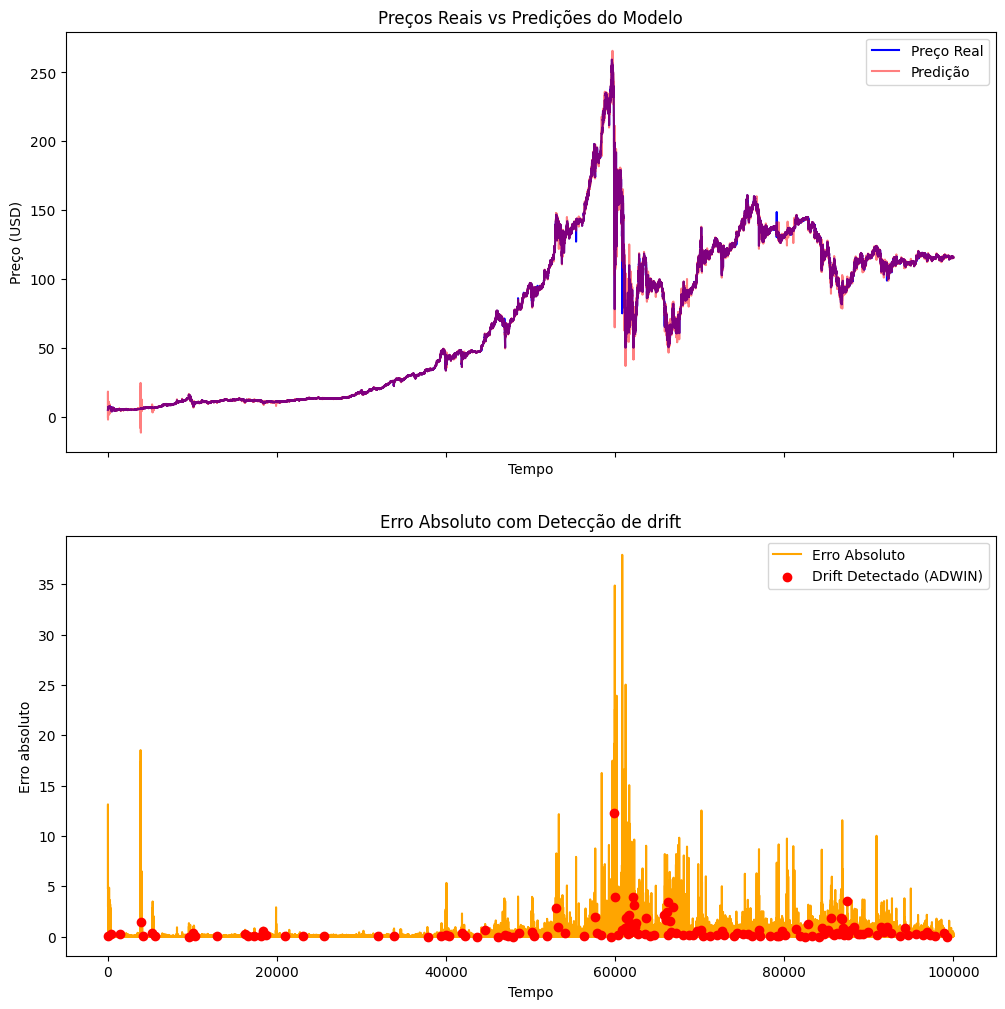

In [52]:
# len(df) não tava funcionando então usei isso
x_vals = list(range(100000))

# valores reais
valores_reais = df['Close'].values

fig, axs = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

axs[0].plot(x_vals, valores_reais, label="Preço Real", color='blue')
axs[0].plot(x_vals, predicoes, label="Predição", color='red', alpha=0.5) #tudo que for igual vai ficar roxo (azul+vermelho)
axs[0].set_ylabel("Preço (USD)")
axs[0].set_title("Preços Reais vs Predições do Modelo")
axs[0].set_xlabel("Tempo")
axs[0].legend()

axs[1].plot(x_vals, erros, label="Erro Absoluto", color='orange')
axs[1].scatter(drifts, [erros[i] for i in drifts], 
               color='red', label="Drift Detectado (ADWIN)", zorder=5)
axs[1].set_xlabel("Tempo")
axs[1].set_ylabel("Erro absoluto")
axs[1].set_title("Erro Absoluto com Detecção de drift")
axs[1].legend()

plt.show()

Como podemos ver tivemos metricas de avalição como:

RMSE: 0.79 
R²: 1.00

Para o modelo que nos mostra que ele foi altamente bem em sua predição, e podemos comfirmar isso olhando o primeiro grafico acima, e podemos ver que em sua maior parte ele está roxo que quer dizer que o modelo acertou ou chegou altamente certo do valor real e poucos lugares mostrando vermelho ou azul, que seriam predições erradas do modelo.

Analisando o erro absoluto com detecção de drifts, vemos que existe muitos drifts e um pico de erro absoluto em 60.000, que é quando há uma grande queda inesperada no valor do bitcoin. Com esse grafico podemos dizer que o modelo está constante maior parte do tempo tendo erros menores que ~10 que não é grande problemas.

